In [18]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [19]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    original_data = pd.read_parquet(r'../data/FAOSTAT/clean_data/all_tables_processed/full_country_dataset_v4_TOTALS.parquet')
original_data.head()

,Area Code,Year,Area,Agricultural_Soils_Emissions_(CO2eq)_(AR5)_kt,Agrifood_Systems_Waste_Disposal_Emissions_(CO2eq)_(AR5)_kt,Agrifood_systems_Emissions_(CO2eq)_(AR5)_kt,Burning_-_Crop_residues_Emissions_(CO2eq)_(AR5)_kt,Crop_Residues_Emissions_(CO2eq)_(AR5)_kt,Emissions_from_crops_Emissions_(CO2eq)_(AR5)_kt,Emissions_from_livestock_Emissions_(CO2eq)_(AR5)_kt,...,Pre-_and_Post-_Production_Emissions_(CO2eq)_(AR5)_kt,Rice_Cultivation_Emissions_(CO2eq)_(AR5)_kt,Savanna_fires_Emissions_(CO2eq)_(AR5)_kt,Synthetic_Fertilizers_Emissions_(CO2eq)_(AR5)_kt,Waste_Emissions_(CO2eq)_(AR5)_kt,Country_area_Area_1000_ha,Population_-_Est._&_Proj._Total_Population_-_Both_sexes_1000_No,Gross_Domestic_Product_Annual_growth_US$_per_capita_%,Gross_Domestic_Product_Value_US$_million_USD,Gross_Domestic_Product_Value_US$_per_capita_USD
0,1,1990,Armenia,544.8665,250.1941,2997.3446,2.5811,25.8905,28.4716,1251.4710,...,835.9032,0.0,4.2975,82.7595,606.975,2974.0,3574.555,-39.711192,1251.976343,350.246770
1,1,1991,Armenia,544.8665,250.1941,2997.3446,2.5811,25.8905,28.4716,1251.4710,...,835.9032,0.0,4.2975,82.7595,606.975,2974.0,3574.555,-39.711192,1251.976343,350.246770
2,1,1992,Armenia,544.8665,250.1941,2997.3446,2.5811,25.8905,28.4716,1251.4710,...,835.9032,0.0,4.2975,82.7595,606.975,2974.0,3574.555,-39.711192,1251.976343,350.246770
3,1,1993,Armenia,473.5815,266.3624,1841.7261,3.7940,27.6395,31.4335,1075.1042,...,500.8966,0.0,4.2975,82.7595,572.050,2974.0,3457.349,-3.484703,1168.728174,338.041712
4,1,1994,Armenia,418.9650,282.6547,1848.5462,3.3673,22.6045,25.9718,1059.8895,...,568.0747,0.0,4.2975,38.6370,567.245,2974.0,3373.713,10.243232,1257.275245,372.668109


# Clean up country names

In [20]:
data = original_data.copy()
data = data[data['Area Code'] < 1000] # Select only countries
data.rename(columns = {'Population_-_Est._&_Proj._Total_Population_-_Both_sexes_1000_No':'Population_1000s'}, inplace = True)

In [21]:
print(f"Initial Nr. of Unique Countries and Country Codes: {data['Area'].nunique()} | {data['Area Code'].nunique()}")
# Group by 'Area' and 'Area Code', then count the number of unique Area Codes for each Area
area_code_counts = data.groupby('Area')['Area Code'].nunique()

# Filter areas with more than one unique area code
areas_with_multiple_codes = area_code_counts[area_code_counts > 1]

# Display results
print("Countries with multiple codes:", areas_with_multiple_codes)

Initial Nr. of Unique Countries and Country Codes: 243 | 243
Countries with multiple codes: Series([], Name: Area Code, dtype: int64)


Filter geopandas countries

In [22]:
country_codes = pd.read_csv('../data/FAOSTAT/clean_data/fao_country_codes_corrected.csv')

# Group by 'Area' and 'Area Code', then count the number of unique Area Codes for each Area
area_code_counts = country_codes.groupby('Area')['Area Code'].nunique()

# Filter areas with more than one unique area code
areas_with_multiple_codes = area_code_counts[area_code_counts > 1]

# Display results
print(areas_with_multiple_codes)

Series([], Name: Area Code, dtype: int64)


In [23]:
print(f"Initial Nr. of Unique Countries and Country Codes: {data['Area'].nunique()} | {data['Area Code'].nunique()}")

# Merge with corrected countries to filter
data = pd.merge(data.drop('Area', axis=1), country_codes, how='left', on='Area Code')

# Correct some data
data['Area'] = np.where(data['Area Code'] == 351, 'China', data['Area'])
data = data.dropna(subset=['Area'])

# Drop USSR and Yugoslav SFR. Drop China Mainland and keep only China
data = data[~data['Area'].isin(['USSR', 'Yugoslav SFR'])]
data = data[data['Area Code'] != 41]

# After filtering
print(f"Final Nr. of Unique Countries and Country Codes: {data['Area'].nunique()} | {data['Area Code'].nunique()}")

Initial Nr. of Unique Countries and Country Codes: 243 | 243
Final Nr. of Unique Countries and Country Codes: 203 | 203


# Select cluster columns and data for cluster

## Only last 10 years

In [24]:
data = data[data['Year'] >= 2011]

## Drop low emission countries (<10000 agrifood total emissions)

In [25]:
# low_df = data.groupby('Area')['Agrifood_systems_Emissions_(CO2eq)_(AR5)_kt'].sum().sort_values(ascending=False).tail(50).to_frame().reset_index()
# low_df[low_df['Agrifood_systems_Emissions_(CO2eq)_(AR5)_kt'] < 10000]['Area'].to_list()

low_emission_countries = ['Bahamas',
 'Bhutan',
 'Faroe Islands',
 'Malta',
 'Barbados',
 'New Caledonia',
 'Vanuatu',
 'Comoros',
 'Solomon Is.',
 'Samoa',
 'Maldives',
 'Cabo Verde',
 'Sao Tome and Principe',
 'Saint Lucia',
 'R�union',
 'Antigua and Barbuda',
 'French Polynesia',
 'Guadeloupe',
 'Tonga',
 'Saint Vincent and the Grenadines',
 'Seychelles',
 'Grenada',
 'Martinique',
 'Micronesia (Federated States of)',
 'Dominica',
 'Saint Kitts and Nevis',
 'Kiribati',
 'Marshall Islands',
 'Cook Islands',
 'Nauru',
 'Tuvalu',
 'Monaco',
 'Niue',
 'Tokelau',
 'Svalbard and Jan Mayen Islands']

data = data[~data['Area'].isin(low_emission_countries)]

In [26]:
# cluster_columns = [
#         # 'Agricultural_Soils_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Agrifood_Systems_Waste_Disposal_Emissions_(CO2eq)_(AR5)_kt',
#         # # 'Agrifood_systems_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Burning_-_Crop_residues_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Crop_Residues_Emissions_(CO2eq)_(AR5)_kt',
#         'Emissions_from_crops_Emissions_(CO2eq)_(AR5)_kt',
#         'Emissions_from_livestock_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Emissions_on_agricultural_land_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Enteric_Fermentation_Emissions_(CO2eq)_(AR5)_kt',
#         'Farm_gate_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Fertilizers_Manufacturing_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Fires_in_humid_tropical_forests_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Fires_in_organic_soils_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Food_Household_Consumption_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Food_Packaging_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Food_Processing_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Food_Retail_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Food_Transport_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Forest_fires_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Forestland_Emissions_(CO2eq)_(AR5)_kt',
#         'Land_Use_change_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Manure_Management_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Manure_applied_to_Soils_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Manure_left_on_Pasture_Emissions_(CO2eq)_(AR5)_kt',
#         'Net_Forest_conversion_Emissions_(CO2eq)_(AR5)_kt',
#         'Pesticides_Manufacturing_Emissions_(CO2eq)_(AR5)_kt',
#         'Pre-_and_Post-_Production_Emissions_(CO2eq)_(AR5)_kt',
#         'Rice_Cultivation_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Savanna_fires_Emissions_(CO2eq)_(AR5)_kt',
#         'Synthetic_Fertilizers_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Waste_Emissions_(CO2eq)_(AR5)_kt',
#         # 'Country_area_Area_1000_ha',
#         # 'Gross_Domestic_Product_Annual_growth_US$_per_capita_%',
#         # 'Gross_Domestic_Product_Value_US$_million_USD',
#         # 'Gross_Domestic_Product_Value_US$_per_capita_USD',
# ]

cluster_columns = [
    # 'Agrifood_systems_Emissions_(CO2eq)_(AR5)_kt',
        'Farm_gate_Emissions_(CO2eq)_(AR5)_kt',
        'Land_Use_change_Emissions_(CO2eq)_(AR5)_kt',
        'Pre-_and_Post-_Production_Emissions_(CO2eq)_(AR5)_kt',
        # 'Burning_-_Crop_residues_Emissions_(CO2eq)_(AR5)_kt',
        # 'Crop_Residues_Emissions_(CO2eq)_(AR5)_kt',
        # 'Rice_Cultivation_Emissions_(CO2eq)_(AR5)_kt',
        'Emissions_from_crops_Emissions_(CO2eq)_(AR5)_kt',
        'Emissions_from_livestock_Emissions_(CO2eq)_(AR5)_kt',
]

core_cols = ['Area', 'Area Code', 'Population_1000s']
group_cols = ['Area', 'Area Code']

In [27]:
grouped_data = data[cluster_columns+core_cols].groupby(group_cols).sum().reset_index()
grouped_data = grouped_data[grouped_data['Population_1000s'] > 0]

In [28]:
grouped_data.shape

(168, 8)

In [29]:
grouped_data = grouped_data.set_index(group_cols)
grouped_data.sum(axis=1).sort_values(ascending=False).head(10)

Area                      Area Code
China                     351          4.661934e+07
India                     100          3.546380e+07
Brazil                    21           2.350925e+07
United States of America  231          1.813806e+07
Indonesia                 101          1.599719e+07
Dem. Rep. Congo           250          8.306500e+06
Russia                    185          6.978705e+06
Pakistan                  165          6.950215e+06
Mexico                    138          4.937330e+06
Nigeria                   159          4.916562e+06
dtype: float64

# Calculate also per capita emissions (Clustering done with both: total and per capita)

In [30]:
kmeans_data = grouped_data.copy()
new_cluster_cols = []

# for col in cluster_columns:
#     if "co2" in col.lower():
#         per_capita_col = f"{col}_per-capita"
#         kmeans_data[per_capita_col] = kmeans_data[col].div((kmeans_data['Population_1000s']*1000))
#         new_cluster_cols.append(per_capita_col)

        #drop original column
        # kmeans_data = kmeans_data.drop(col, axis=1)

#Drop population
kmeans_data = kmeans_data.drop('Population_1000s', axis=1)

# K-means with original data (total and per capita emissions)

So I drop population

Fitting data with 2 clusters
Fitting data with 3 clusters
Fitting data with 4 clusters
Fitting data with 5 clusters
Fitting data with 6 clusters
Fitting data with 7 clusters
Fitting data with 8 clusters
Fitting data with 9 clusters
Fitting data with 10 clusters
Fitting data with 11 clusters
Fitting data with 12 clusters
Fitting data with 13 clusters
Fitting data with 14 clusters
Fitting data with 15 clusters
Fitting data with 16 clusters
Fitting data with 17 clusters
Fitting data with 18 clusters


Fitting data with 19 clusters


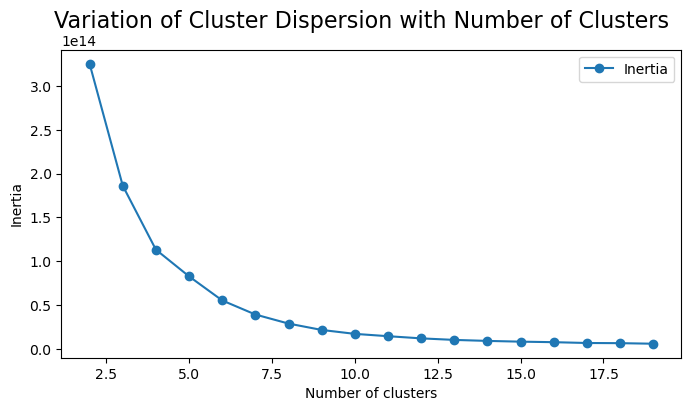

cluster
0    134
4     28
2      3
1      2
3      1
Name: count, dtype: int64
Cluster 0:
[('Afghanistan', 2), ('Albania', 3), ('Algeria', 4), ('Angola', 7), ('Armenia', 1), ('Austria', 11), ('Azerbaijan', 52), ('Bahrain', 13), ('Belarus', 57), ('Belgium', 255), ('Belize', 23), ('Benin', 53), ('Bolivia', 19), ('Bosnia and Herz.', 80), ('Botswana', 20), ('Brunei', 26), ('Bulgaria', 27), ('Burkina Faso', 233), ('Burundi', 29), ('Cambodia', 115), ('Cameroon', 32), ('Central African Rep.', 37), ('Chile', 40), ('Congo', 46), ('Costa Rica', 48), ('Croatia', 98), ('Cuba', 49), ('Cyprus', 50), ('Czechia', 167), ('Czechoslovakia', 51), ('Denmark', 54), ('Djibouti', 72), ('Dominican Rep.', 56), ('Ecuador', 58), ('Egypt', 59), ('El Salvador', 60), ('Eq. Guinea', 61), ('Eritrea', 178), ('Estonia', 63), ('Eswatini', 209), ('Fiji', 66), ('Finland', 67), ('Gabon', 74), ('Gambia', 75), ('Georgia', 73), ('Ghana', 81), ('Greece', 84), ('Guatemala', 89), ('Guinea', 90), ('Guinea-Bissau', 175), ('Guyana',

In [31]:
# Dictionary to store SSE values
sse = {}

for k in range(2, 20):
    print(f"Fitting data with {k} clusters")

    kmeans = KMeans(n_clusters=k, random_state=23)
    kmeans.fit(kmeans_data)

    sse[k] = kmeans.inertia_

# Plotting
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, marker='o', linestyle='-', label="Inertia")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Inertia")
fig.suptitle("Variation of Cluster Dispersion with Number of Clusters", fontsize=16)
plt.legend()
plt.show()

# Apply KMeans with 10 clusters on the scaled log1p-transformed data
n_clusters=5
kmeans = KMeans(n_clusters=n_clusters, random_state=23).fit(kmeans_data)

# Add cluster labels to the DataFrame
kmeans_data['cluster'] = kmeans.labels_
grouped_data['cluster'] = kmeans.labels_
print(grouped_data['cluster'].value_counts())

for cluster in range(n_clusters):
    print(f"Cluster {cluster}:\n{grouped_data[grouped_data['cluster'] == cluster].index.tolist()}\n")

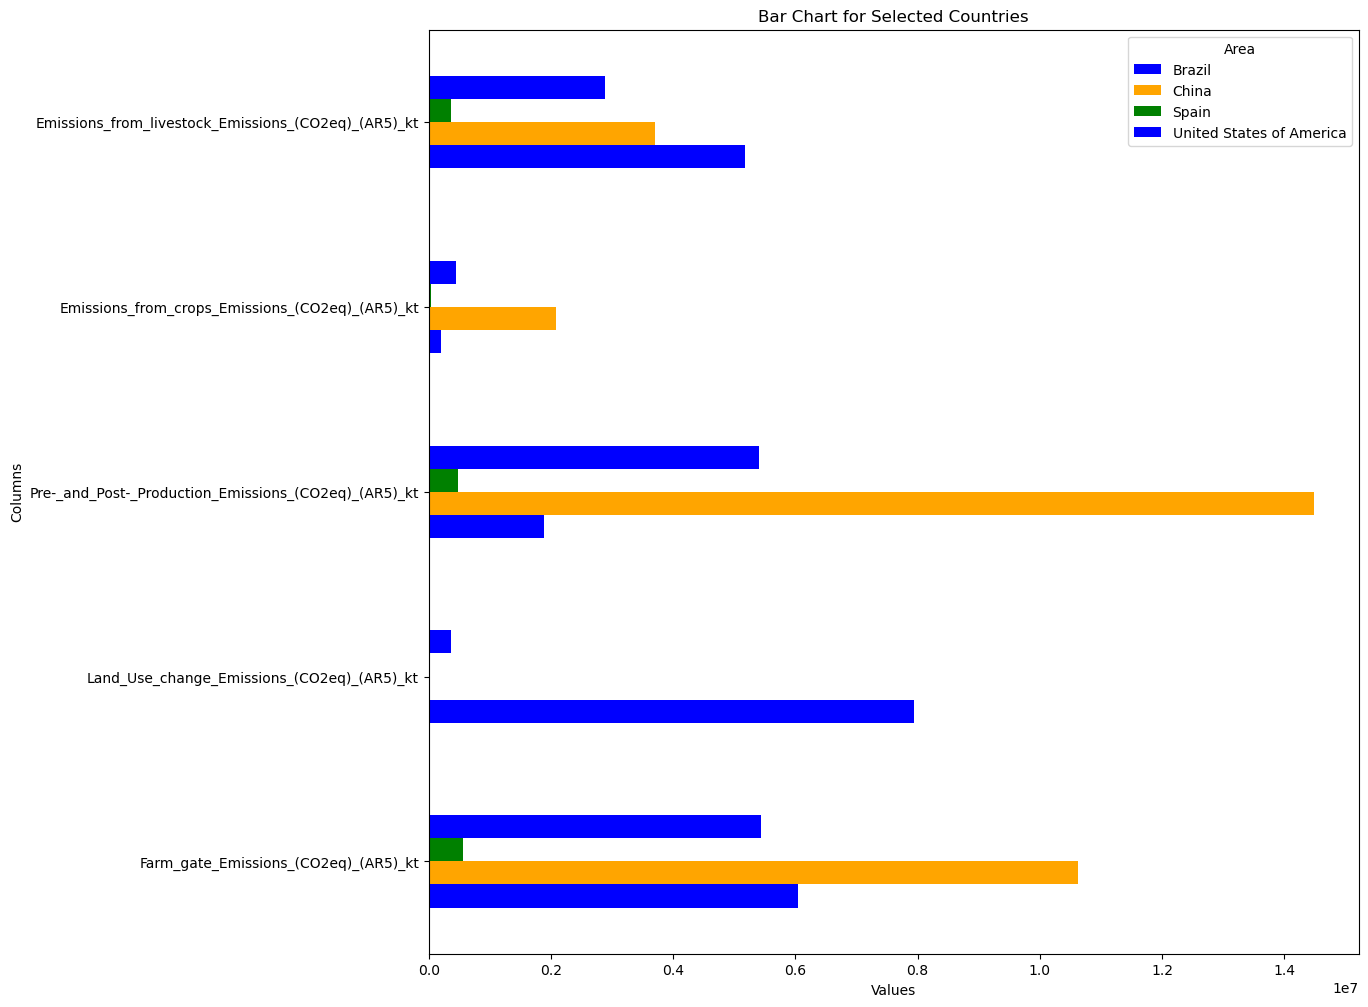

In [33]:
# Define the countries and columns
countries = ['United States of America', 'Brazil', 'China', 'Spain']
columns = cluster_columns

# Reset index and filter data for the specified countries
plot_data = kmeans_data.reset_index()
plot_data = plot_data[plot_data['Area'].isin(countries)]

# Set the 'Area' column as index again and select columns
plot_data = plot_data.set_index('Area')[columns]

# Plot horizontal bar chart with different colors for each country
ax = plot_data.T.plot.barh(figsize=(12, 12), color=['blue', 'orange', 'green'])

# Set titles and labels
plt.title('Bar Chart for Selected Countries')
plt.xlabel('Values')
plt.ylabel('Columns')

# Set log scale for x-axis if needed
# plt.xscale('log')

# Display the plot
plt.show()

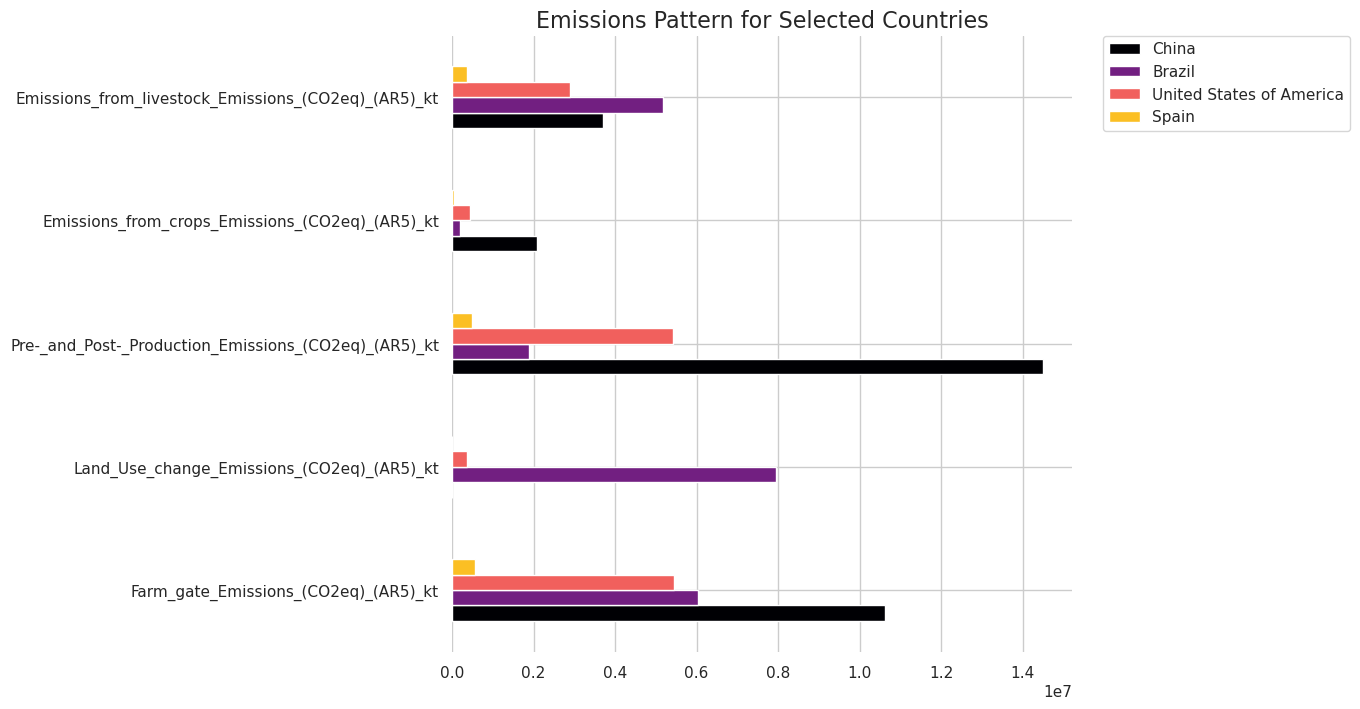

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the custom order for the countries
country_order = ['China', 'Brazil', 'United States of America', 'Spain']

# Reindex the DataFrame based on the custom order
plot_data = plot_data.reindex(country_order)

# Set Seaborn style
sns.set(style="whitegrid")

# Manually selected colors from the magma palette (China: black, Brazil: dark orange, USA: light orange, Spain: dark yellow)
magma_colors = ['#000004', '#721f81', '#f1605d', '#fbbf24']  # Adjusted to match the requested colors

# Create a dictionary to map countries to the selected colors
colors_dict = {
    'China': magma_colors[0],                     # black
    'Brazil': magma_colors[1],                    # dark orange
    'United States of America': magma_colors[2],  # light orange
    'Spain': magma_colors[3]                      # dark yellow
}

# Plot horizontal bar chart with colors from the colors_dict
ax = plot_data.T.plot.barh(
    figsize=(8, 8), 
    color=[colors_dict[country] for country in plot_data.index]
)

# Set titles and labels
plt.title('Emissions Pattern for Selected Countries', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# plt.xlabel('Values', fontsize=14)
# plt.ylabel('Columns', fontsize=14)

# Set Seaborn-like ticks
sns.despine(left=True, bottom=True)

# Display the plot
plt.show()


# Analysis of generated clusters

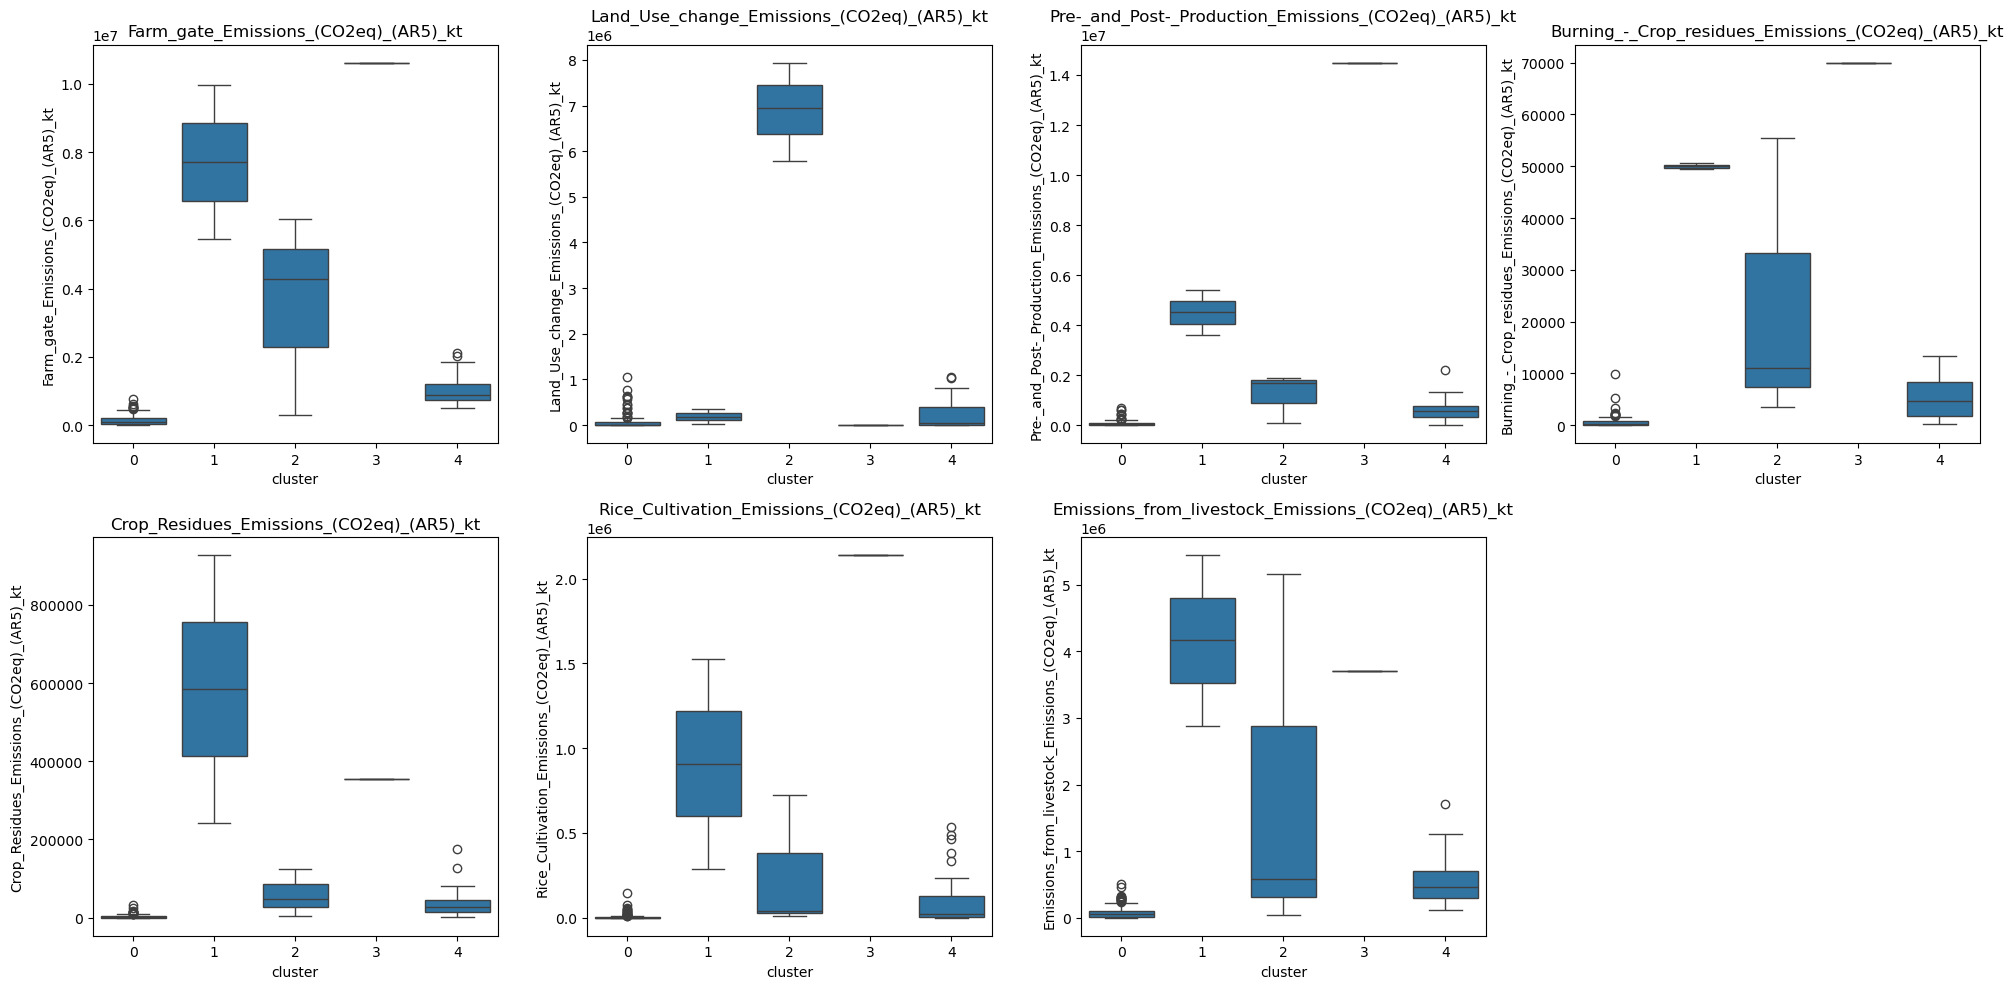

In [811]:
# Define the columns to plot
columns_to_plot = cluster_columns

import math  # Add this import to handle rounding

# Calculate the number of rows and columns for subplots
num_plots = len(columns_to_plot)
cols = 4
rows = math.ceil(num_plots / cols)  # Use math.ceil to round up

# Create subplots with the calculated number of rows and columns
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Generate boxplots for each column
for i, column in enumerate(columns_to_plot):
    sns.boxplot(x='cluster', y=column, data=kmeans_data, ax=axes[i])
    axes[i].set_title(column)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

# Secondary Cluster: Dropping outliers

In [812]:
countries_to_drop = ['India', 'United States of America', 'China', 'Brazil', 'Dem. Rep. Congo', 'Indonesia']

kmeans_data2 = kmeans_data.drop(countries_to_drop)

Fitting data with 2 clusters
Fitting data with 3 clusters
Fitting data with 4 clusters
Fitting data with 5 clusters
Fitting data with 6 clusters
Fitting data with 7 clusters
Fitting data with 8 clusters
Fitting data with 9 clusters
Fitting data with 10 clusters
Fitting data with 11 clusters
Fitting data with 12 clusters
Fitting data with 13 clusters
Fitting data with 14 clusters
Fitting data with 15 clusters
Fitting data with 16 clusters
Fitting data with 17 clusters
Fitting data with 18 clusters
Fitting data with 19 clusters


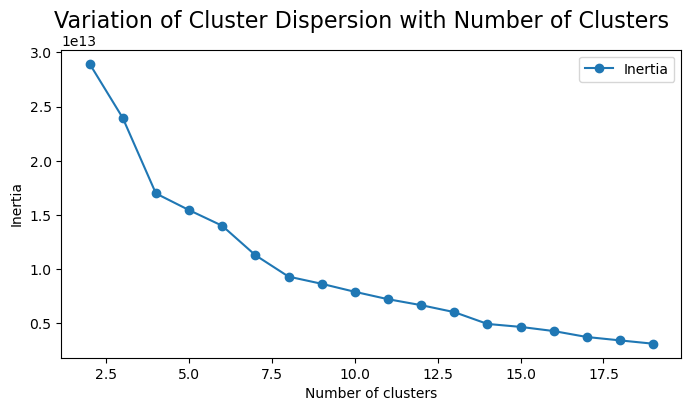

cluster
0    128
1     21
2     13
Name: count, dtype: int64
Cluster 0:
['Afghanistan', 'Albania', 'Algeria', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bosnia and Herz.', 'Botswana', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Rep.', 'Chile', 'Congo', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Czechoslovakia', 'Denmark', 'Djibouti', 'Dominican Rep.', 'Ecuador', 'Egypt', 'El Salvador', 'Eq. Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Fiji', 'Finland', 'Gabon', 'Gambia', 'Georgia', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Iraq', 'Ireland', 'Israel', 'Jamaica', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Moldova', 'Mongolia', 'Montenegro', 'Morocco', 'Namibia', 'Nepal',

In [813]:
# Dictionary to store SSE values
sse = {}

for k in range(2, 20):
    print(f"Fitting data with {k} clusters")

    kmeans = KMeans(n_clusters=k, random_state=23)
    kmeans.fit(kmeans_data2)

    sse[k] = kmeans.inertia_

# Plotting
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, marker='o', linestyle='-', label="Inertia")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Inertia")
fig.suptitle("Variation of Cluster Dispersion with Number of Clusters", fontsize=16)
plt.legend()
plt.show()

# Apply KMeans with 10 clusters on the scaled log1p-transformed data
n_clusters=3
kmeans = KMeans(n_clusters=n_clusters, random_state=23).fit(kmeans_data2)

# Add cluster labels to the DataFrame
kmeans_data2['cluster'] = kmeans.labels_
kmeans_data2.reset_index(inplace=True)

print(kmeans_data2['cluster'].value_counts())

for cluster in range(n_clusters):
    print(f"Cluster {cluster}:\n{kmeans_data2[kmeans_data2['cluster'] == cluster]['Area'].tolist()}\n")

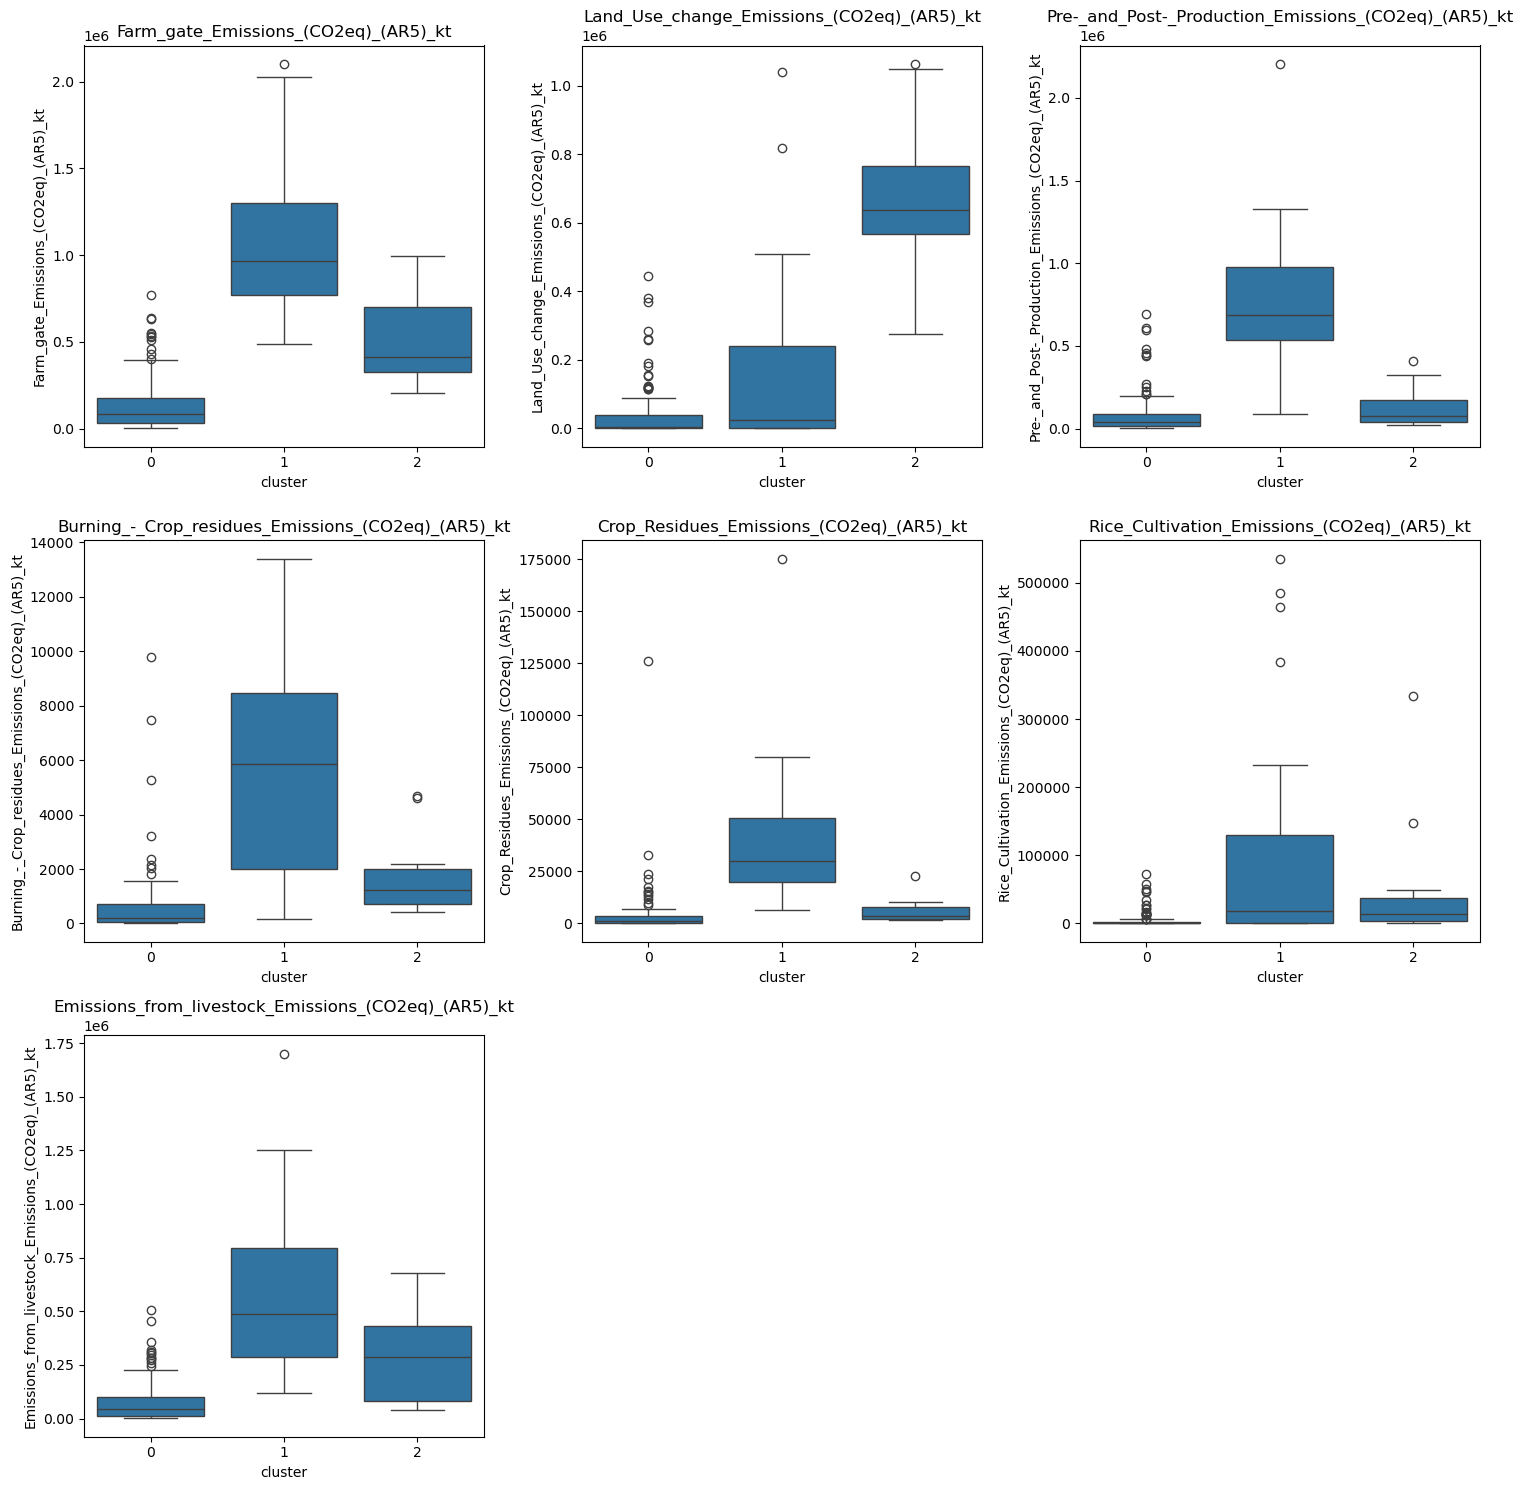

In [814]:
# Define the columns to plot
columns_to_plot = cluster_columns.co

# Calculate the number of rows and columns for subplots
num_plots = len(columns_to_plot)
cols = 3
rows = math.ceil(num_plots / cols)  # Use math.ceil to round up

# Create subplots with the calculated number of rows and columns
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Generate boxplots for each column
for i, column in enumerate(columns_to_plot):
    sns.boxplot(x='cluster', y=column, data=kmeans_data2, ax=axes[i])
    axes[i].set_title(column)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

# Save data for choropleth map

In [815]:
# Manually assign clusters

TOP_CLUSTERS = {
    'India': 4,
    'United States of America': 4,
    'Brazil': 3,
    'Dem. Rep. Congo': 3,
    'Indonesia': 3,
    'China': 5
}

OTHERS_CLUSTER = dict(zip(kmeans_data2['Area'], kmeans_data2['cluster']))

ALL_CLUSTERS = {**OTHERS_CLUSTER, **TOP_CLUSTERS}

In [816]:
data_with_clusters = data.copy()
data_with_clusters['cluster'] = data_with_clusters['Area'].map(ALL_CLUSTERS)

data_with_clusters.to_parquet('../data/FAOSTAT/clean_data/all_tables_processed/full_country_dataset_v4_TOTALS_with_clusters.parquet', index=False)

# Append: Test other clustering inputs

In [817]:
# # Import standard scaler
# from sklearn.preprocessing import StandardScaler

# ss = StandardScaler()

# scaled_data = ss.fit_transform(kmeans_data)

In [818]:
# # Dictionary to store SSE values
# sse = {}

# for k in range(2, 10):
#     print(f"Fitting data with {k} clusters")

#     kmeans = KMeans(n_clusters=k, random_state=23)
#     kmeans.fit(scaled_data)

#     sse[k] = kmeans.inertia_

# # Plotting
# fig = plt.figure(figsize=(8, 4))
# ax = fig.add_subplot()

# x_values = list(sse.keys())
# y_values = list(sse.values())

# ax.plot(x_values, y_values, marker='o', linestyle='-', label="Inertia")
# ax.set_xlabel("Number of clusters")
# ax.set_ylabel("Inertia")
# fig.suptitle("Variation of Cluster Dispersion with Number of Clusters", fontsize=16)
# plt.legend()
# plt.show()

# # Apply KMeans with 10 clusters on the scaled log1p-transformed data
# n_clusters=6
# kmeans = KMeans(n_clusters=n_clusters, random_state=23).fit(scaled_data)

# # Add cluster labels to the DataFrame
# kmeans_data['cluster'] = kmeans.labels_
# grouped_data['cluster'] = kmeans.labels_
# print(grouped_data['cluster'].value_counts())

# for cluster in range(n_clusters):
#     print(f"Cluster {cluster}:\n{grouped_data[grouped_data['cluster'] == cluster].index.tolist()}\n")